<!--NAVIGATION-->
< [聚合与分组](03.08-Aggregation-and-Grouping.ipynb) | [目录](Index.ipynb) | [向量化的字符串操作](03.10-Working-With-Strings.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/03.09-Pivot-Tables.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Pivot Tables

# 数据透视表

> We have seen how the ``GroupBy`` abstraction lets us explore relationships within a dataset.
A *pivot table* is a similar operation that is commonly seen in spreadsheets and other programs that operate on tabular data.
The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data.
The difference between pivot tables and ``GroupBy`` can sometimes cause confusion; it helps me to think of pivot tables as essentially a *multidimensional* version of ``GroupBy`` aggregation.
That is, you split-apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.

上一节我们学习了使用`GroupBy`来处理数据集之间的关系。*数据透视表*也是一个类似的操作，我们经常会在电子表格或其他处理表格数据的程序中看到它。数据透视表将列状的数据作为输入，然后将它们组合到一个二维的表格中，通过这种组合结果提供数据在多个维度上的统计数据。数据透视表和`GroupBy`之间的区别经常会造成一些混乱；如果我们将数据透视表想象成一个*多维*版本的`GroupBy`聚合，会容易很多。也就是说，依然通过拆分-应用-组合的步骤，不过不是在一维的索引上进行，而是在二维的表格中进行。

## Motivating Pivot Tables

## 进入数据透视表

> For the examples in this section, we'll use the database of passengers on the *Titanic*, available through the Seaborn library (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)):

本小节的例子，我们将采用*泰坦尼克*的乘客数据，同样来自Seaborn库（参见[使用Seaborn进行可视化](04.14-Visualization-With-Seaborn.ipynb)）：

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [2]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


> This contains a wealth of information on each passenger of that ill-fated voyage, including gender, age, class, fare paid, and much more.

这个数据集包含了每一个乘客在他们的那次致命之旅中的很多信息，包括性别、年龄、舱位、票价等等。

## Pivot Tables by Hand

## 手动生成数据透视表

> To start learning more about this data, we might begin by grouping according to gender, survival status, or some combination thereof.
If you have read the previous section, you might be tempted to apply a ``GroupBy`` operation–for example, let's look at survival rate by gender:

在深入分析数据之前，我们首先根据性别和存活状态的相关性进行分组。根据上一节的内容，你可能会自然而然地使用`GroupBy`操作，例如，让我们来获得不同性别的存活率：

In [3]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


> This immediately gives us some insight: overall, three of every four females on board survived, while only one in five males survived!

这个结果立刻能给我们一些数据的内在意义：普遍来说，四分之三的女性都存活了下来，而只有五分之一的男性存活了下来！

> This is useful, but we might like to go one step deeper and look at survival by both sex and, say, class.
Using the vocabulary of ``GroupBy``, we might proceed using something like this:
we *group by* class and gender, *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and then *unstack* the hierarchical index to reveal the hidden multidimensionality. In code:

这很有用，但是我们可能希望进一步了解根据性别和舱位来统计存活率。如果我们用`GroupBy`的方法来描述这个过程的话，那么很可能是这样的：我们使用舱位和性别来*分组*，*选择*存活状态，*应用*平均值聚合操作，将结果的分组*组合*起来，然后*展开*成层次化的索引来展示隐藏的高维度。代码如下：

In [4]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


> This gives us a better idea of how both gender and class affected survival, but the code is starting to look a bit garbled.
While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use.
This two-dimensional ``GroupBy`` is common enough that Pandas includes a convenience routine, ``pivot_table``, which succinctly handles this type of multi-dimensional aggregation.

结果给了我们一个更好的关于性别和舱位是如何影响存活率的视角，但是代码已经开始显得有点混乱和难以阅读了。当我们采用之前的知识来实现这个操作流的每一步的时候，代码会变得越来越长，将会越来越难以使用和阅读。这种二维的`GroupBy`对于在Pandas中进行普通分组统计时是足够的，而透视表`pivot_table`，能简洁的处理这种多维度的聚合操作。

## Pivot Table Syntax

## 数据透视表语法

> Here is the equivalent to the preceding operation using the ``pivot_table`` method of ``DataFrame``s:

下面是我们使用`DataFrame`的`pivot_table`来实现这个操作的版本：

In [5]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


> This is eminently more readable than the ``groupby`` approach, and produces the same result.
As you might expect of an early 20th-century transatlantic cruise, the survival gradient favors both women and higher classes.
First-class women survived with near certainty (hi, Rose!), while only one in ten third-class men survived (sorry, Jack!).

上面的语法明显比`groupby`版本要易读多了，两者的结果是一致的。结果告诉我们如果要搭乘20世纪初的跨大西洋游轮的话，生存几率更加青睐于女性和高级舱位。头等舱女性几乎全部存活（Rose你好），而三等舱的男性只有十分之一的几率存活（Jack抱歉）。

译者注：Jack和Rose是1997年电影《泰坦尼克号》的男女主角名字，导演是James Carmeron。

### Multi-level pivot tables

### 多层透视表

> Just as in the ``GroupBy``, the grouping in pivot tables can be specified with multiple levels, and via a number of options.
For example, we might be interested in looking at age as a third dimension.
We'll bin the age using the ``pd.cut`` function:

就像`GroupBy`那样，数据透视表的分组也可以指定多层次，还可以指定其他多个参数。例如，我们可能想要将年龄作为第三个维度。我们可以使用`pd.cut`将年龄进行分桶：

In [6]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

> We can apply the same strategy when working with the columns as well; let's add info on the fare paid using ``pd.qcut`` to automatically compute quantiles:

我们也可以将相同的方法应用到列上；下面我们在列上加上船票费用分组，使用`pd.qcut`将费用按比例自动分桶：

In [7]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

> The result is a four-dimensional aggregation with hierarchical indices (see [Hierarchical Indexing](03.05-Hierarchical-Indexing.ipynb)), shown in a grid demonstrating the relationship between the values.

结果是一个四维的统计表，行和列都具有层次化的索引（参见[层次化索引](03.05-Hierarchical-Indexing.ipynb)），以表格的形式展示了对应四个不同维度的聚合数据。

### Additional pivot table options

### 其他透视表参数

> The full call signature of the ``pivot_table`` method of ``DataFrame``s is as follows:

`DataFrame`的`pivot_table`方法的完整签名如下：

```python
# pivot_table的签名，Pandas版本0.24.2
pd.pivot_table(
    data, # DataFrame，当为方法时，这里是self
    values=None, # 用来聚合的列
    index=None, # 行索引，行分组的条件
    columns=None, # 列索引，列分组的条件
    aggfunc='mean', # 聚合函数，默认平均值
    fill_value=None, # NA值的替代值
    margins=False, # 总计，行与列相加的结果
    dropna=True, # 是否移除含有NA值的列
    margins_name='All', # 总计的行和列的标签
)
```

> We've already seen examples of the first three arguments; here we'll take a quick look at the remaining ones.
Two of the options, ``fill_value`` and ``dropna``, have to do with missing data and are fairly straightforward; we will not show examples of them here.

前三个参数（除data外）前面的例子中已经介绍过了；这里我们简单的介绍余下的几个参数。其中的`fill_value`和`dropna`与数据集的缺失值相关，前面我们也都看到过；这里我们就不举例了。

> The ``aggfunc`` keyword controls what type of aggregation is applied, which is a mean by default.
As in the GroupBy, the aggregation specification can be a string representing one of several common choices (e.g., ``'sum'``, ``'mean'``, ``'count'``, ``'min'``, ``'max'``, etc.) or a function that implements an aggregation (e.g., ``np.sum()``, ``min()``, ``sum()``, etc.).
Additionally, it can be specified as a dictionary mapping a column to any of the above desired options:

`aggfunc`参数指定数据透视表使用的聚合函数，默认是平均值`'mean'`。就像`GroupBy`中一样，聚合函数可以通过函数名称的字符串来指定（例如``'sum'``、``'mean'``、``'count'``、``'min'``、``'max'``等）。除此之外，也可以通过一个字典将列与聚合函数对应起来作为`aggfunc`的参数。

In [8]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

> Notice also here that we've omitted the ``values`` keyword; when specifying a mapping for ``aggfunc``, this is determined automatically.

上面的例子中，`values`参数也被忽略了；当我们将列和聚合函数映射的字典传递到`aggfunc`参数时，进行聚合的列显然是不需要指定的。

> At times it's useful to compute totals along each grouping.
This can be done via the ``margins`` keyword:

很多时候，对每个组进行总计（或者小计）是很有用的。这可以通过指定`margins`参数来计算：

In [9]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


> Here this automatically gives us information about the class-agnostic survival rate by gender, the gender-agnostic survival rate by class, and the overall survival rate of 38%.
The margin label can be specified with the ``margins_name`` keyword, which defaults to ``"All"``.

结果最后一行展示了所有性别不同舱位的存活率，最后一列展示了所有舱位不同性别的存活率，而右下角的数字代表总体存活率，约为38%。总计（或小计）的标签可以通过`margins_name`参数来制定，默认为`"All"`。

## Example: Birthrate Data

## 例子：出生率数据

> As a more interesting example, let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC).
This data can be found at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv
(this dataset has been analyzed rather extensively by Andrew Gelman and his group; see, for example, [this blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

下面来看一个更有趣的例子，使用由疾控中心提供的可自由获取使用的美国的人口出生数据。这个数据集可以在https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv 找到（Andrew Gelman和他的团队深入分析了这个数据集，例如可以参见[这篇博文](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)）：

In [10]:
# 如果你没有该数据集，可以用下面这条命令来下载它
# !curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [10]:
births = pd.read_csv('data/births.csv')

> Taking a look at the data, we see that it's relatively simple–it contains the number of births grouped by date and gender:

大致浏览一遍这个数据集，发现它其实相对来说很简单，包括某年某月某日出生的男孩和女孩的个体数：

In [11]:
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


> We can start to understand this data a bit more by using a pivot table.
Let's add a decade column, and take a look at male and female births as a function of decade:

我们可以通过使用数据透视表来更好的理解这个数据集。让我们加一列年代，来看一下每十年男孩和女孩的出生总数：

In [12]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


> We immediately see that male births outnumber female births in every decade.
To see this trend a bit more clearly, we can use the built-in plotting tools in Pandas to visualize the total number of births by year (see [Introduction to Matplotlib](04.00-Introduction-To-Matplotlib.ipynb) for a discussion of plotting with Matplotlib):

我们会立刻发现男孩的出生人数在每一个年代都超过了女孩。为了更加清晰地看到这个趋势，我们可以使用Pandas內建的图表工具来展示每年的男孩女孩的出生总数情况（参见[Matplotlib介绍](04.00-Introduction-To-Matplotlib.ipynb)）：

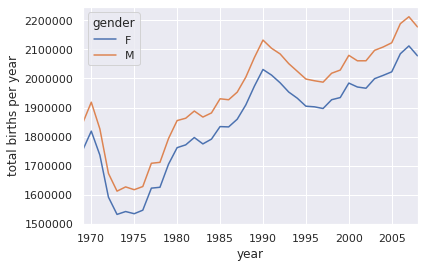

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # 设置使用seaborn风格图表
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

> With a simple pivot table and ``plot()`` method, we can immediately see the annual trend in births by gender. By eye, it appears that over the past 50 years male births have outnumbered female births by around 5%.

使用一个简单的数据透视表和內建的`plot()`方法，我们可以很容易的画出区分性别的出生数趋势图。用肉眼观测，可知在过去的50年中，男孩出生数大致比女孩出生数高出5%。

### Further data exploration

### 进一步数据分析

> Though this doesn't necessarily relate to the pivot table, there are a few more interesting features we can pull out of this dataset using the Pandas tools covered up to this point.
We must start by cleaning the data a bit, removing outliers caused by mistyped dates (e.g., June 31st) or missing values (e.g., June 99th).
One easy way to remove these all at once is to cut outliers; we'll do this via a robust sigma-clipping operation:

虽然下面的内容不一定与数据透视表有关，但是我们使用目前学习到的Pandas知识，就能从数据集中获得更多有趣的特征。首先我们应该对数据进行一定清洗，删除由于错误输入日期导致的离群值（例如6月31日）或者缺失值（例如6月99日）。一次性删除这些离群数据的简单办法是通过一种叫sigma-clipping的稳健统计操作：

In [14]:
# 求出出生数的25%,50%和75%位置的值
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1] # mu为中位数
sig = 0.74 * (quartiles[2] - quartiles[0]) # sigma的值为75%位置与25%位置差的0.74倍

> This final line is a robust estimate of the sample mean, where the 0.74 comes from the interquartile range of a Gaussian distribution (You can learn more about sigma-clipping operations in a book I coauthored with Željko Ivezić, Andrew J. Connolly, and Alexander Gray: ["Statistics, Data Mining, and Machine Learning in Astronomy"](http://press.princeton.edu/titles/10159.html) (Princeton University Press, 2014)).

最后一行代码是样本平均的稳健估计，0.74来源于标准正态分布的四分位距（你可以在作者与Željko Ivezić、Andrew J. Connolly和Alexander Gray合著的书["Statistics, Data Mining, and Machine Learning in Astronomy"](http://press.princeton.edu/titles/10159.html)(Princeton University Press, 2014)中学习到更多有关sigma-clipping方法的知识）。

译者注：对于标准正态分布来说，均值为0，四分位距位于[-0.67448, 0, 0.67448]的位置，因此 IQR = Q3 - Q1 = 0.67448- (-0.67448) = 1.34896，得 $\frac{1}{1.34896}=0.74131$。可以用以下代码进行简单验证：

```python
In [20]: a = np.random.standard_normal(10000)

In [21]: iq = np.percentile(a, [25, 50, 75])

In [22]: iq
Out[22]: array([-0.6510475 ,  0.02099125,  0.68378426])

In [23]: 1/(iq[2] - iq[0])
Out[23]: 0.749158077468436
```

> With this we can use the ``query()`` method (discussed further in [High-Performance Pandas: ``eval()`` and ``query()``](03.12-Performance-Eval-and-Query.ipynb)) to filter-out rows with births outside these values:

然后我们可以使用`query()`方法来过滤掉偏离中位数5倍sigma值之外的所有数据（`query()`方法我们会在[高性能Pandas: eval() 和 query()](03.12-Performance-Eval-and-Query.ipynb)小节中详细讨论）：

In [15]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

> Next we set the ``day`` column to integers; previously it had been a string because some columns in the dataset contained the value ``'null'``:

下面我们将日期`day`列设为整数类型；原本该列具有字符串类型因为数据集中该列存在值`'null'`：

In [16]:
# 将day列设置为整数类型
births['day'] = births['day'].astype(int)

> Finally, we can combine the day, month, and year to create a Date index (see [Working with Time Series](03.11-Working-with-Time-Series.ipynb)).
This allows us to quickly compute the weekday corresponding to each row:

最后，我们可以将年月日合并在一起成为一个时间序列（参见[在时间序列上操作](03.11-Working-with-Time-Series.ipynb)）。这令我们可以很方便的求出每一行日期是周几：

In [17]:
# 使用年月日构造一个时间序列
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek

> Using this we can plot births by weekday for several decades:

然后我们就可以按照星期中的天数来绘制出生数图：

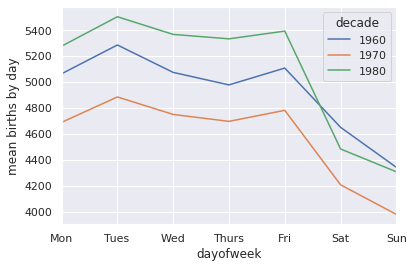

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

> Apparently births are slightly less common on weekends than on weekdays! Note that the 1990s and 2000s are missing because the CDC data contains only the month of birth starting in 1989.

很明显，出生数在休息日要比工作日少。还要注意到1990和2000年代数据缺失，原因是疾控中心的数据从1989年开始就只包含月份信息了。

> Another intersting view is to plot the mean number of births by the day of the *year*.
Let's first group the data by month and day separately:

另一个有趣的视角是分析每年每天的平均出生数。首先我们将月份和日期进行分组求平均值：

In [19]:
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

> The result is a multi-index over months and days.
To make this easily plottable, let's turn these months and days into a date by associating them with a dummy year variable (making sure to choose a leap year so February 29th is correctly handled!)

结果当然，是一个月份和日期的多重索引数据集。然后需要简单的绘制图表，我们可以将上面的月份日期随便放在一个闰年年份中形成完整的时间序列（闰年是为了保证2月29日也能包含在结果集中）：

In [20]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


> Focusing on the month and day only, we now have a time series reflecting the average number of births by date of the year.
From this, we can use the ``plot`` method to plot the data. It reveals some interesting trends:

我们只需要关注数据集中的月份和日期，上面的结果已经是一个时间序列上每天出生数的平均值。然后我们就可以使用`plot`方法来绘制图表。结果会反映一些有趣的趋势：

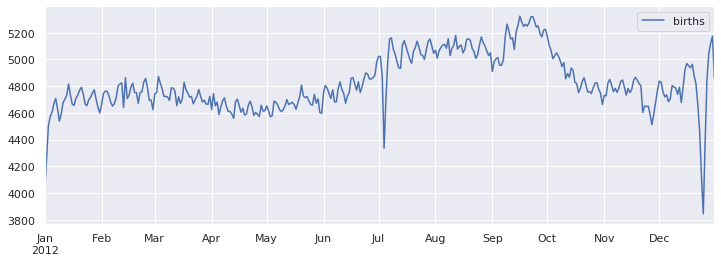

In [21]:
# 绘制每年每天的出生数平均值
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

> In particular, the striking feature of this graph is the dip in birthrate on US holidays (e.g., Independence Day, Labor Day, Thanksgiving, Christmas, New Year's Day) although this likely reflects trends in scheduled/induced births rather than some deep psychosomatic effect on natural births.
For more discussion on this trend, see the analysis and links in [Andrew Gelman's blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/) on the subject.
We'll return to this figure in [Example:-Effect-of-Holidays-on-US-Births](04.09-Text-and-Annotation.ipynb#Example:-Effect-of-Holidays-on-US-Births), where we will use Matplotlib's tools to annotate this plot.

上图这个引人注目的结果表明出生率在美国假期的日期中都会下降（例如独立日、劳动节、感恩节、圣诞节和新年），当然这并不代表节日对自然出生率在生物学上造成了影响，而是反映了医学上对生育的额外处理的趋势。对于有关这个趋势更多的讨论，可以参看[Andrew Gelman's blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)。我们会在[第四章第九节例子:节日对美国生育率的影响](04.09-Text-and-Annotation.ipynb#Example:-Effect-of-Holidays-on-US-Births)中继续深入讨论这个图表，学习使用Matplotlib工具来标注这个图表。

> Looking at this short example, you can see that many of the Python and Pandas tools we've seen to this point can be combined and used to gain insight from a variety of datasets.
We will see some more sophisticated applications of these data manipulations in future sections!

看完了这个简短的例子，你就可以发现我们已经学习到的很多Python和Pandas的工具可以联合使用来深入分析不同的数据集以获得需要的结果。在后续章节中我们会看到一些对于数据的操作更复杂的应用。

<!--NAVIGATION-->
< [聚合与分组](03.08-Aggregation-and-Grouping.ipynb) | [目录](Index.ipynb) | [向量化的字符串操作](03.10-Working-With-Strings.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/03.09-Pivot-Tables.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
